# set meta

## terminal execution

In [83]:
! pip3 install matplotlib

    100% |████████████████████████████████| 11.6MB 110kB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/a6/fc/36e52d0ae2aa502b211f1bcd2fdeec72d343d58224eabcdddc1bcb052db1/numpy-1.19.4-cp36-cp36m-manylinux1_x86_64.whl
    100% |████████████████████████████████| 1.1MB 414kB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/8a/bb/488841f56197b13700afd5658fc279a2025a39e22449b7cf29864669b15d/pyparsing-2.4.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl
    100% |████████████████████████████████| 2.2MB 371kB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/ee/ff/48bde5c0f013094d729fe4b0316ba2a24774b3ff1c52d924a8a4cb04078a/six-1.15.0-py2.py3-none-any.whl


## user input

In [13]:
basePath = '~/Documents/kagglai/'
srcPath = 'src'
dataPath = 'dat'

'''
projectName = 'melbourne_housing_snapshot'
rawInputPath = 'melb_data.csv'
'''
projectName = 'titanic'
trainInputPath = 'train.csv'
testDataPath = 'test.csv'
sampleOutputPath = 'gender_submission.csv'

randomSeed = 0

## dependencies

In [5]:
# general
import os
import datetime
from operator import itemgetter

# data manipulation
import pandas as pd
import numpy as np

# modeling
from sklearn.model_selection import train_test_split

# models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# metrics
from sklearn.metrics import mean_absolute_error, mean_squared_log_error

# hyper-parameter tuning
from sklearn.model_selection import cross_val_score
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

# visualization
from matplotlib import pyplot as plt
from skopt.plots import plot_convergence

## initialization

In [14]:
### Initialization
BASE_DIRECTORY = os.path.dirname(basePath)
CODE_DIRECTORY = os.path.join(BASE_DIRECTORY, srcPath)
DATA_DIRECTORY = os.path.join(BASE_DIRECTORY, dataPath)

PROJECT_DIRECTORY = os.path.join(DATA_DIRECTORY, projectName)
IN_DIRECTORY = os.path.join(PROJECT_DIRECTORY, 'in')
OUT_DIRECTORY = os.path.join(PROJECT_DIRECTORY, 'out')
RAW_TRAIN_PATH = os.path.join(IN_DIRECTORY, trainInputPath)
RAW_TEST_PATH = os.path.join(IN_DIRECTORY, testDataPath)
RAW_SAMPLE_PATH = os.path.join(IN_DIRECTORY, sampleOutputPath)



X_TST_PATH = os.path.join(IN_DIRECTORY, 'x_tst.feather')
X_TRN_PATH = os.path.join(IN_DIRECTORY, 'x_trn.feather')
Y_TST_PATH = os.path.join(IN_DIRECTORY, 'y_tst.feather')
Y_TRN_PATH = os.path.join(IN_DIRECTORY, 'y_trn.feather')

## custom classes and functions

In [15]:
def spit_data(data, yName, randomSeed=0):
    x = rawDataframe.drop(yName, axis=1)
    y = rawDataframe[yName]
    train_x, test_x, train_y, test_y = train_test_split(x, y, random_state = randomSeed)
    test_y.to_frame().reset_index().to_feather(Y_TST_PATH)
    test_x.reset_index().to_feather(X_TST_PATH)
    train_y.to_frame().reset_index().to_feather(Y_TRN_PATH)
    train_x.reset_index().to_feather(X_TRN_PATH)    

In [16]:
def get_mae(model, x_trn, x_val, y_trn, y_val):
    model.fit(x_trn, y_trn)
    y_p_val = model.predict(x_val)
    y_p_trn = model.predict(x_trn)
    mae_trn = mean_absolute_error(y_trn, y_p_trn)
    mae_val = mean_absolute_error(y_val, y_p_val)
    return mae_trn, mae_val


In [17]:
def log_spaced_int_list(start=0.1, end=3, nPoints=50, multFactor=5):
    l = list(multFactor*np.logspace(start, end, nPoints, endpoint=True))
    l = [int(i) for i in l]
    l = list(dict.fromkeys(l))
    if 0 in l:
        l.remove(0)
    if 1 in l:
        l.remove(1)
    return l

In [18]:
def feature_engineering(x, y):
    melbourne_features = ['Rooms', 'Bathroom', 'Landsize', 'Lattitude', 'Longtitude']
    x = x[melbourne_features]
    return x, y


In [19]:
def rf_hyperopt_randomsearch():
    rf = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=200,random_state=randomSeed, oob_score=True)
    distributions = dict(n_estimators = [50,100,150], 
                         max_features =  ["auto", "sqrt", "log2"],
                         max_depth=[50,100,200],
                         oob_score=[True],
                         min_samples_leaf=[20,50,100])

    search_rf = RandomizedSearchCV(rf, distributions, random_state=0)
    search = search_rf.fit(x, y)
    search.best_params_

In [20]:
def skot_hyperopt(space, model, x, y):
    @use_named_args(space)
    def objective(**params):
        model.set_params(**params)

        return -np.mean(cross_val_score(model, x, y, cv=5, n_jobs=-1,
                                        scoring="neg_mean_absolute_error"))
    res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)
    return res_gp

# data prep

## data input

In [21]:
rawDataframe = pd.read_csv(RAW_TRAIN_PATH)


In [22]:
rawDataframe.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [23]:
yName = 'Survived'
spit_data(rawDataframe, yName, randomSeed)

In [24]:
x = pd.read_feather(X_TRN_PATH)
y = pd.read_feather(Y_TRN_PATH)
xy = pd.concat([x,y],axis=1,sort=False)

## exploratory data analysis

In [25]:
xy.head()

,index,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,index,Survived
0,105,106,3,"Mionoff, Mr. Stoytcho",male,28.0,0,0,349207,7.8958,None,S,105,0
1,68,69,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,7.9250,None,S,68,1
2,253,254,3,"Lobb, Mr. William Arthur",male,30.0,1,0,A/5. 3336,16.1000,None,S,253,0
3,320,321,3,"Dennis, Mr. Samuel",male,22.0,0,0,A/5 21172,7.2500,None,S,320,0
4,706,707,2,"Kelly, Mrs. Florence ""Fannie""",female,45.0,0,0,223596,13.5000,None,S,706,1


In [26]:
xy.describe()

,index,PassengerId,Pclass,Age,SibSp,Parch,Fare,index,Survived
count,668.000000,668.000000,668.000000,535.000000,668.000000,668.000000,668.000000,668.000000,668.000000
mean,444.911677,445.911677,2.305389,29.900000,0.534431,0.392216,32.373621,444.911677,0.386228
std,259.966783,259.966783,0.837377,14.487993,1.161739,0.822509,50.632021,259.966783,0.487249
min,0.000000,1.000000,1.000000,0.670000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,215.250000,216.250000,2.000000,21.000000,0.000000,0.000000,7.925000,215.250000,0.000000
50%,444.500000,445.500000,3.000000,29.000000,0.000000,0.000000,14.500000,444.500000,0.000000
75%,673.500000,674.500000,3.000000,38.000000,1.000000,0.000000,31.275000,673.500000,1.000000
max,889.000000,890.000000,3.000000,80.000000,8.000000,6.000000,512.329200,889.000000,1.000000


## pre-process

## feature engineer

In [14]:
x, y = feature_engineering(x, y)

## data check

In [ ]:
# data leakage
# train-serving skew
# high correlations

# baseline

# automl

# select model

# train

In [12]:
x_trn, x_val, y_trn, y_val = train_test_split(x, y, random_state = randomSeed)

In [13]:
x_trn.shape,x_val.shape

((7638, 5), (2547, 5))

In [64]:
# Decision Tree
dtr = DecisionTreeRegressor(random_state=randomSeed)
dtr.fit(x_trn, y_trn)

357.1749258095487 124854.3591643764 348.5608178020612


In [66]:
# Random Forest
rf = RandomForestRegressor(random_state=randomSeed)
rf.fit(x_trn, y_trn)

34784.93945028174 93615.52314354338 1.691265950810363


# evaluate

In [ ]:
# decision tree
y_p_trn = dtr.predict(x_trn)
y_p_val = dtr.predict(x_val)

mae_trn = mean_absolute_error(y_p_trn, y_trn)
mae_val = mean_absolute_error(y_p_val, y_val)
diff = mae_val - mae_trn
ratio = diff/mae_trn
print(mae_trn, mae_val, ratio )

In [ ]:
# random forest
y_p_trn = rf.predict(x_trn)
y_p_val = rf.predict(x_val)

mae_trn = mean_absolute_error(y_p_trn, y_trn)
mae_val = mean_absolute_error(y_p_val, y_val)

diff = mae_val - mae_trn
ratio = diff/mae_trn
print(mae_trn, mae_val, ratio )

In [2]:
# classification
'''
score
precision
recall
AUC PR
AUC ROC
Accuracy
Log loss
F1
'''

'\nscore\nprecision\nrecall\nAUC PR\nAUC ROC\n'

In [3]:
# regression
'''
MAE
RMSE
RMSLE
'''

'\nMAE\n'

# tune

In [57]:
dtr = DecisionTreeRegressor(max_depth=None,
                            max_leaf_nodes=700,
                            min_samples_split=2,
                            min_samples_leaf=1)

space  = [  Integer(50, 2000, name='max_depth'),
            Integer(50, 1500, name='max_leaf_nodes'),
            Integer(2, 50, name='min_samples_split'),
            Integer(1, 50, name='min_samples_leaf')
         ]

res_gp = skot_hyperopt(space, dtr, x, y)

/home/alex/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/alex/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/alex/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/alex/.local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best score=110144.6802
Best parameters:
max_depth=1152
max_leaf_nodes=1246
min_samples_split=16
min_samples_leaf=8



<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

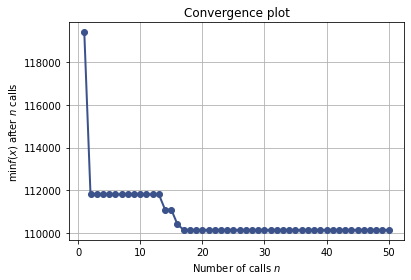

In [58]:
print("Best score=%.4f" % res_gp.fun)
print("""Best parameters:
max_depth=%d
max_leaf_nodes=%d
min_samples_split=%d
min_samples_leaf=%d
""" % (res_gp.x[0], res_gp.x[1],
                            res_gp.x[2], res_gp.x[3]))
plot_convergence(res_gp)

In [27]:
rf = RandomForestRegressor(criterion='mse', max_features = "sqrt", random_state=randomSeed, oob_score=True)



In [31]:
print("Best score=%.4f" % res_gp_rf.fun)
print("""Best parameters:
n_estimators=%d
max_depth=%d
min_samples_leaf=%d
min_samples_split=%d
""" % (res_gp_rf.x[0], res_gp_rf.x[1],res_gp_rf.x[2], res_gp_rf.x[3]))
plot_convergence(res_gp_rf)

Best score=94479.8626
Best parameters:
- n_estimators=300
- max_depth=50
- min_samples_leaf=1
- min_samples_split=2



# compare with others

# full data

In [52]:
dtr = DecisionTreeRegressor(max_depth=1152,
                            max_leaf_nodes=728,
                            min_samples_split=12,
                            min_samples_leaf=8)
dtr.fit(x,y)
y_p = dtr.predict(x)
mae = mean_absolute_error(y_p, y)
dtr.score(x,y), mae

(0.553507633283657, 80594.28243587608)

In [ ]:
rf = RandomForestRegressor(criterion='mse', 
                           max_features = "sqrt", 
                           random_state=randomSeed, 
                           oob_score=True,
                           n_estimators=300,
                           max_depth=50,
                           min_samples_leaf=1,
                           min_samples_split=2)
rf.fit(x,y)
y_p = rf.predict(x)
mae = mean_absolute_error(y_p, y)
rf.oob_score_, rf.score(x,y), mae

## model check

# test

In [48]:
# read test data
x_test = pd.read_feather(X_TST_PATH)
y_test = pd.read_feather(Y_TST_PATH)

In [49]:
x_test, y_test = feature_engineering(x_test, y_test)

In [50]:
# Random Forest
y_pred = rf.predict(x_test)
mean_absolute_error(y_pred, y_test)

92963.12992378572

In [51]:
# Decision Tree
y_pred = dtr.predict(x_test)
mean_absolute_error(y_pred, y_test)

108844.27591047403

# predict

# post-process